In [165]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

**Defining Functions**

In [166]:
# Function to get stock data using yfinance
def get_stock_data(symbol):
    stock = yf.Ticker(symbol)
    data = stock.history(period="max")
    data.reset_index(inplace=True)
    return data

In [167]:
# Function to convert revenue values to floats
def parse_revenue(revenue_str):
    revenue_str = revenue_str.replace('₹', '').strip()
    if 'B' in revenue_str:
        return float(revenue_str.replace('B', '')) * 1e9  # Convert from billions
    elif 'T' in revenue_str:
        return float(revenue_str.replace('T', '')) * 1e12  # Convert from trillions
    else:
        return float(revenue_str.replace(',', ''))  # Convert normally if no B or T

In [168]:
# Function to scrape revenue data from a given URL
def get_revenue_data(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table and all rows
    table = soup.find('table', {'class': "table"})
    if table is None:
        print(f"Table not found for {url}!")
        return pd.DataFrame()

    rows = table.find_all('tr')

    revenue_data = []
    for row in rows:
        cols = row.find_all('td')

        # Check if there are at least 2 columns (Date and Revenue) ignoring the Change column
        if len(cols) >= 2:
            # Extract the year from the <span class="year"> tag
            year = cols[0].find('span', {'class': 'year'}).text if cols[0].find('span', {'class': 'year'}) else cols[0].text.strip()

            # Extract the revenue value and clean it up
            revenue = parse_revenue(cols[1].text)

            revenue_data.append((year, revenue))

    # Create DataFrame with columns Date and Revenue
    df = pd.DataFrame(revenue_data, columns=['Date', 'Revenue'])
    return df

In [169]:
# Function to generate graphs for stock and revenue data
def make_graph(stock_data, revenue_data, stock):
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=("Historical Share Price", "Historical Revenue"), vertical_spacing=0.3)

    stock_data_specific = stock_data[stock_data['Date'] <= '2021-06-14']
    revenue_data_specific = revenue_data[revenue_data['Date'] <= '2021-04-30']

    # Plotting share price
    fig.add_trace(go.Scatter(x=pd.to_datetime(stock_data_specific['Date']), y=stock_data_specific['Close'].astype("float"), name="Share Price"), row=1, col=1)

    # Plotting revenue
    fig.add_trace(go.Scatter(x=pd.to_datetime(revenue_data_specific['Date']), y=revenue_data_specific['Revenue'].astype("float"), name="Revenue"), row=2, col=1)

    # Update layout
    fig.update_xaxes(title_text="Date", row=1, col=1)
    fig.update_xaxes(title_text="Date", row=2, col=1)
    fig.update_yaxes(title_text="Price ($US)", row=1, col=1)
    fig.update_yaxes(title_text="Revenue ($US)", row=2, col=1)
    fig.update_layout(showlegend=False, height=900, title=stock, xaxis_rangeslider_visible=True)

    # Show and save the graph
    fig.show()
    fig.write_html(f'{stock}.html')


In [170]:
# URLs for bank revenue data
urls = {
    "JPMorgan Chase": "https://companiesmarketcap.com/inr/jp-morgan-chase/revenue/",
    "Wells Fargo": "https://companiesmarketcap.com/inr/wells-fargo/revenue/",
    "Bank of America": "https://companiesmarketcap.com/inr/bank-of-america/revenue/",
    "Goldman Sachs": "https://companiesmarketcap.com/inr/goldman-sachs/revenue/",
    "Morgan Stanley": "https://companiesmarketcap.com/inr/morgan-stanley/revenue/",
    "Capital One": "https://companiesmarketcap.com/inr/capital-one/revenue/",
    "American Express": "https://companiesmarketcap.com/inr/american-express/revenue/"
}

In [171]:
start = "2010-01-01"
end = '2024-1-01'
JPM = yf.download('JPM',start,end)
BOA = yf.download('BAC',start,end)
WF = yf.download('WFC',start,end)
GS = yf.download('GS',start,end)
MS = yf.download('MS',start,end)
CF = yf.download('COF',start,end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


**EDA**

In [172]:
df = JPM
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,41.790001,42.990002,41.669998,42.849998,29.335238,35460500
2010-01-05,42.790001,43.840000,42.779999,43.680000,29.903465,41208300
2010-01-06,43.450001,44.090000,43.310001,43.919998,30.067753,27729000
2010-01-07,43.790001,45.119999,43.610001,44.790001,30.663347,44864700
2010-01-08,44.369999,44.700001,44.080002,44.680000,30.588066,33110100


In [173]:
df = df.drop(['Adj Close'], axis=1)

In [174]:
df.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0


<ipython-input-175-7e0cbba4b6ba>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,i+1)


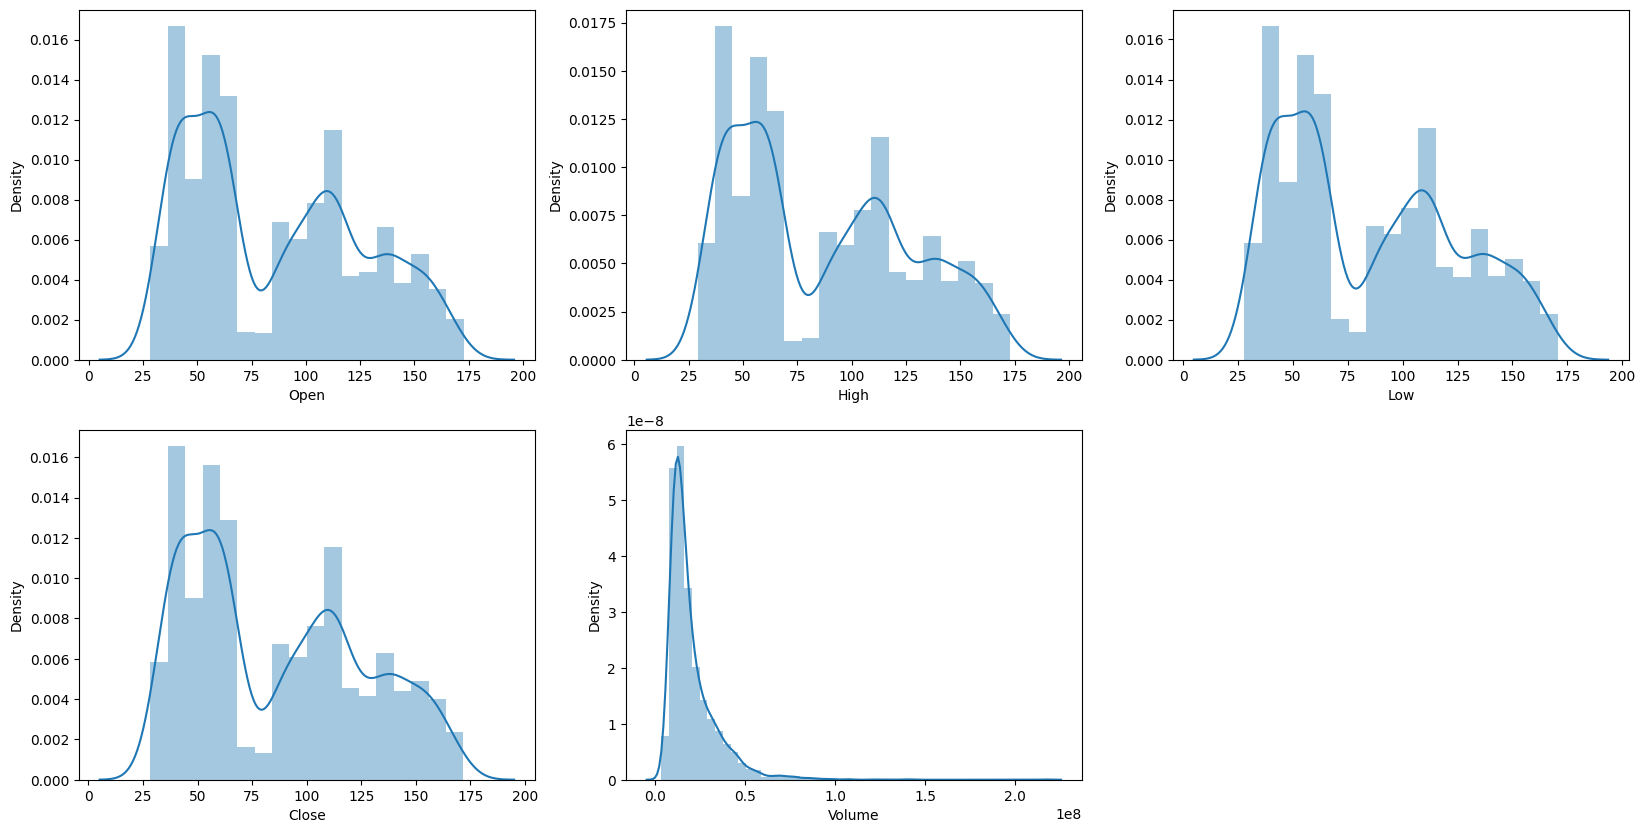

In [175]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']

import matplotlib.pyplot as plt
import seaborn as sb
plt.subplots(figsize=(20,10))

for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.distplot(df[col])
plt.show()

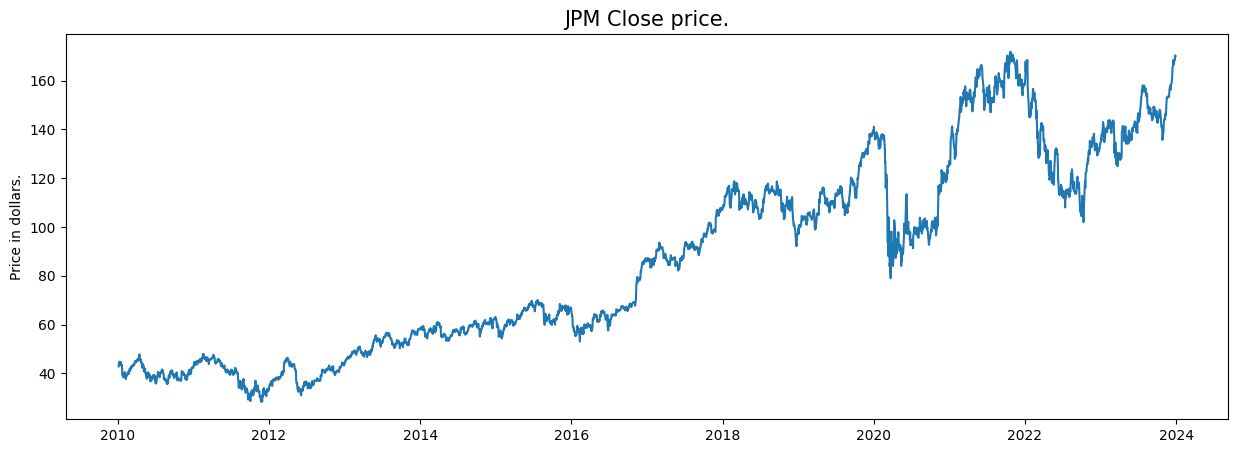

In [176]:
plt.figure(figsize=(15,5))
plt.plot(df['Close'])
plt.title('JPM Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()

<ipython-input-177-5b5e4c588302>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,i+1)


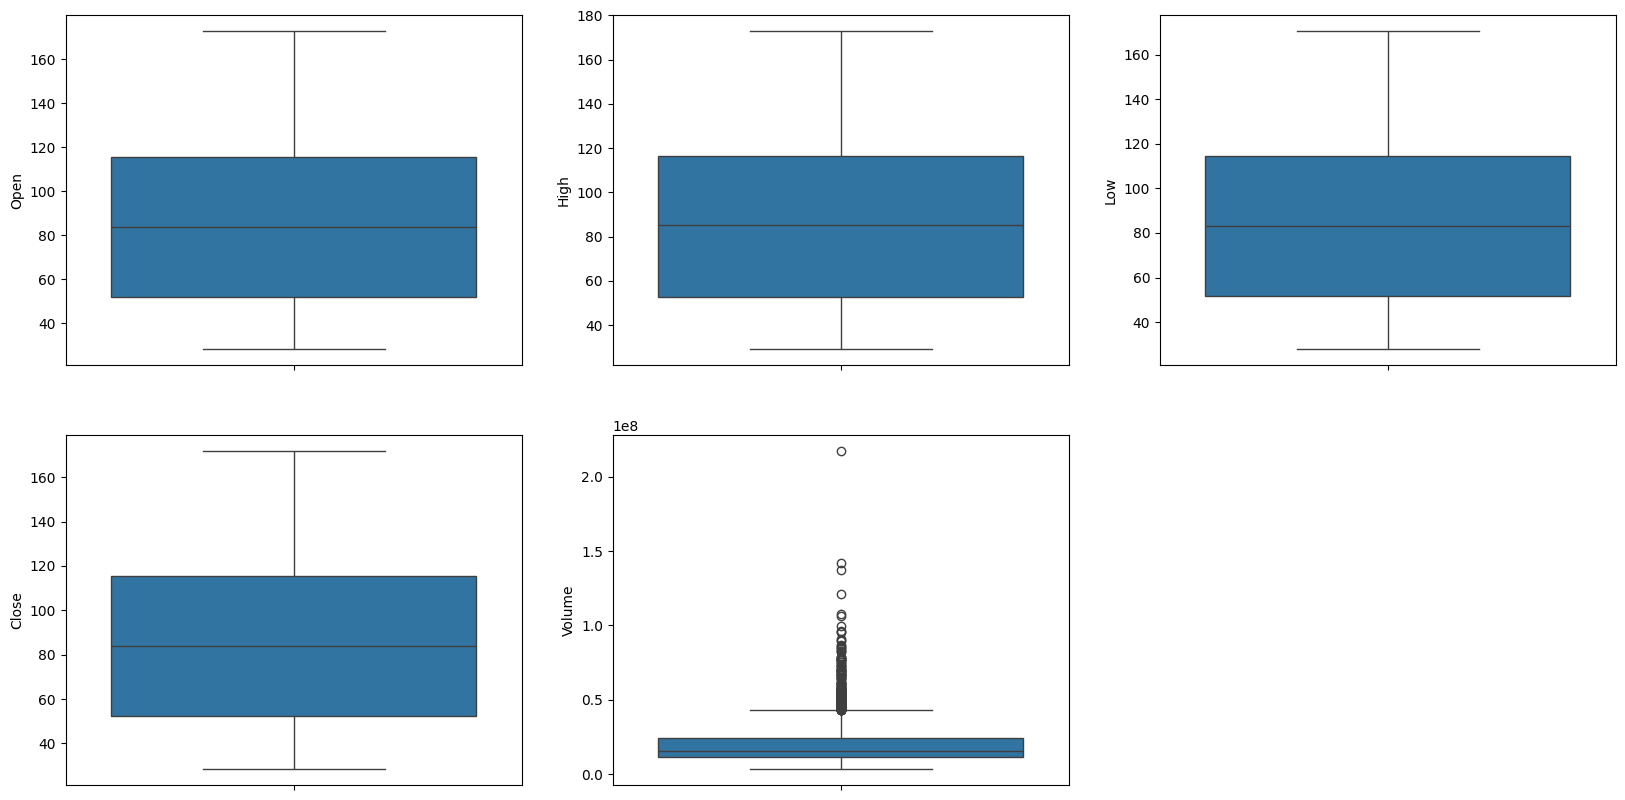

In [177]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.boxplot(df[col])
plt.show()

In [178]:
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format="%m-%d-%Y")
df['Date'] = df['Date'].dt.strftime('%d-%m-%Y')
df['Date'] = df['Date'].astype(str)
splitted = df['Date'].str.split('-', expand=True)

df['Day'] = splitted[1].astype('int')
df['Month'] = splitted[0].astype('int')
df['Year'] = splitted[2].astype('int')
df.head()

,Date,Open,High,Low,Close,Volume,Day,Month,Year
0,04-01-2010,41.790001,42.990002,41.669998,42.849998,35460500,1,4,2010
1,05-01-2010,42.790001,43.840000,42.779999,43.680000,41208300,1,5,2010
2,06-01-2010,43.450001,44.090000,43.310001,43.919998,27729000,1,6,2010
3,07-01-2010,43.790001,45.119999,43.610001,44.790001,44864700,1,7,2010
4,08-01-2010,44.369999,44.700001,44.080002,44.680000,33110100,1,8,2010


<ipython-input-179-81c000de264f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,i+1)


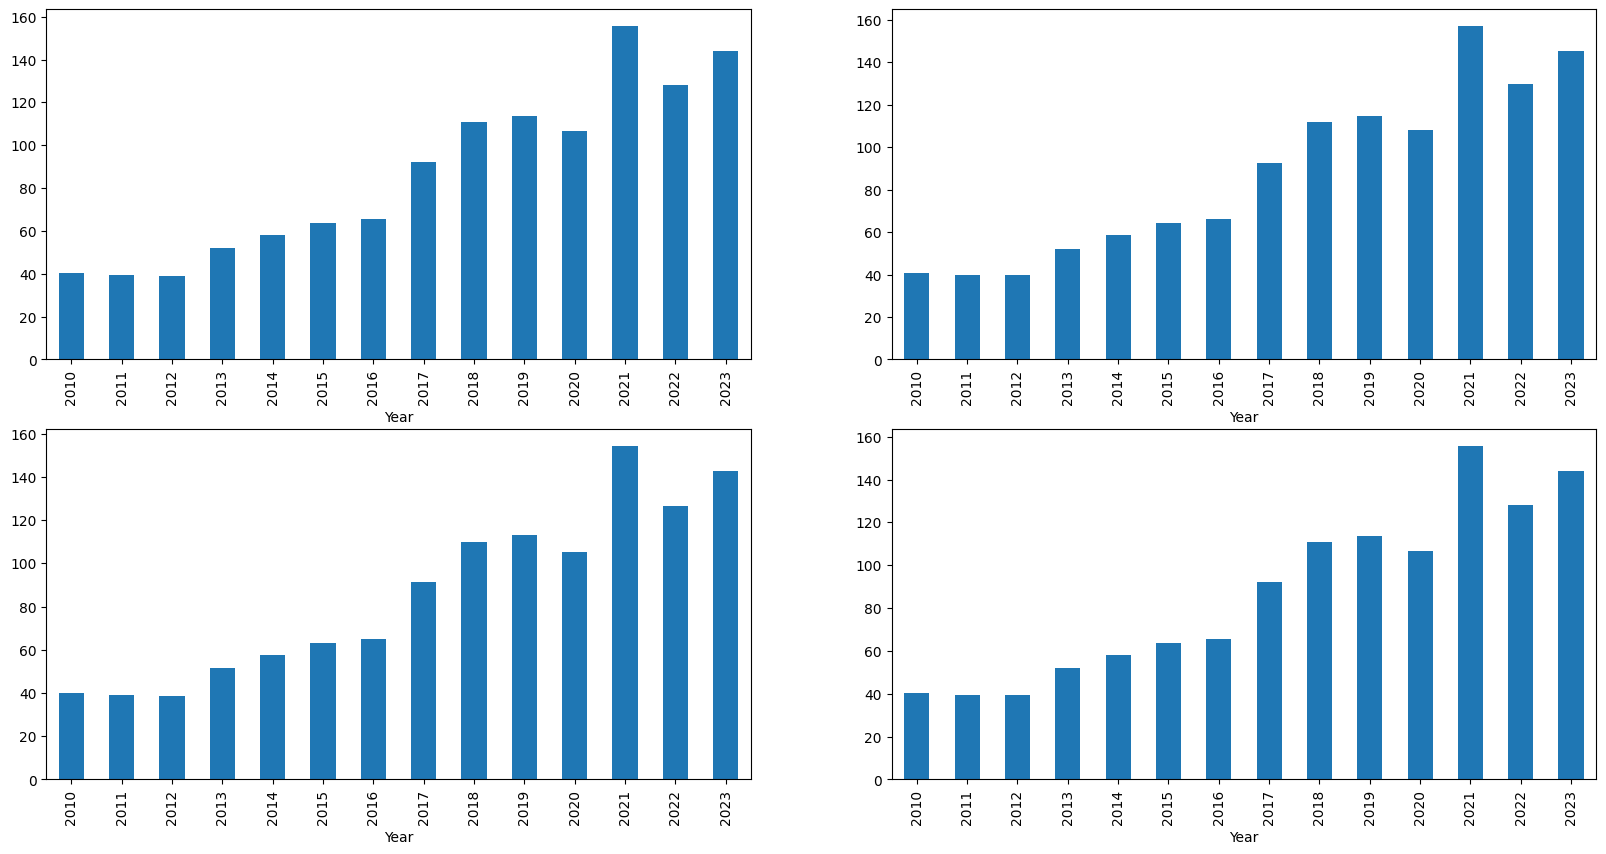

In [179]:
plt.subplots(figsize=(20,10))

for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
  plt.subplot(2,2,i+1)
  df.groupby('Year')[col].mean().plot.bar()
plt.show()

In [180]:
import numpy as np
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

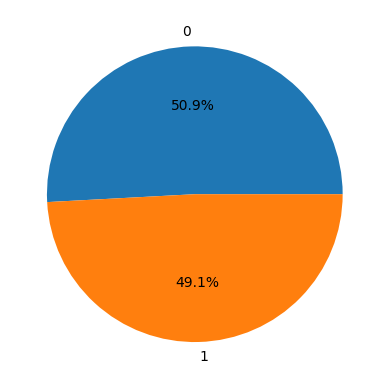

In [181]:
plt.pie(df['Target'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

**Data Preprocessing**

In [182]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df['scaled_values'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))

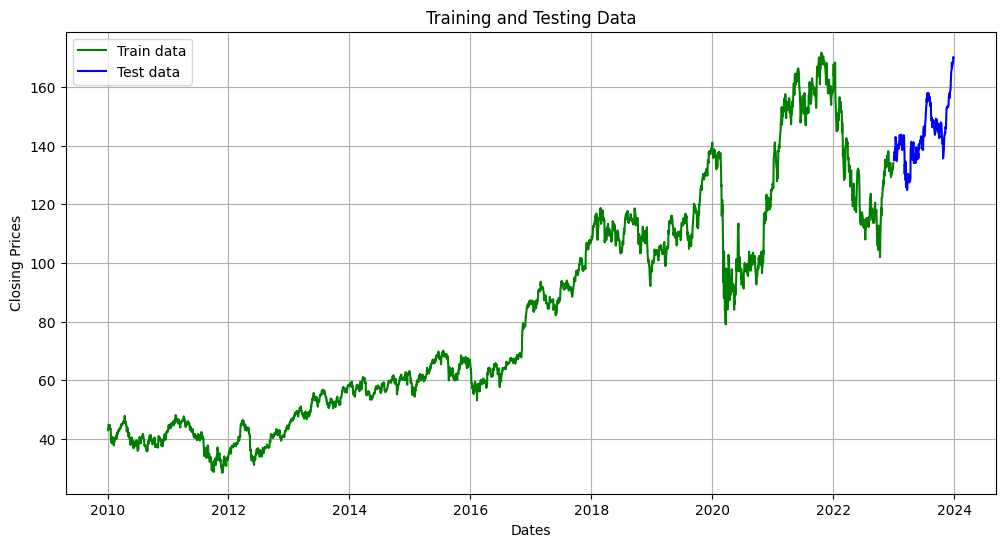

In [183]:
import matplotlib.pyplot as plt

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
train_data = df[df['Date'] < '01-01-2023']
test_data = df[df['Date'] >= '01-01-2023']

# Plotting the data
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')

# Plotting train data in green
plt.plot(train_data['Date'], train_data['Close'], color='green', label='Train data')

# Plotting test data in blue
plt.plot(test_data['Date'], test_data['Close'], color='blue', label='Test data')

plt.legend()
plt.title('Training and Testing Data')
plt.show()


In [184]:
#Training Data
x_train = []
y_train = []

for i in range(60, len(train_data['scaled_values'])):
    x_train.append(train_data['scaled_values'][i-60:i])
    y_train.append(train_data['scaled_values'][i])

x_train, y_train = np.array(x_train), np.array(y_train)

# converting it back to 3D array as required by LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [185]:
#Testing Data
x_test = []
y_test = test_data['scaled_values']

for i in range(60, len(test_data)):
    x_test.append(test_data['scaled_values'][i-60:i])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [186]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [187]:
#Initialize model
model = Sequential()

#LSTM layer 1
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.25))

#LSTM layer 2
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

#LSTM layer 3
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

#LSTM layer 4
model.add(LSTM(units = 50))
model.add(Dropout(0.25))

#Final layer
model.add(Dense(units = 1))
model.summary()



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                       │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [188]:
#Compiling Model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [189]:
#Fitting training data into the model
model.fit(x_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - loss: 0.0461
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - loss: 0.0041
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - loss: 0.0035
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - loss: 0.0033
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - loss: 0.0030
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - loss: 0.0026
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - loss: 0.0035
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - loss: 0.0032
Epoch 9/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - loss: 0.0025
Epoch 10/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - loss: 0.0031


In [190]:
#Predict on test data
predicted_stock_price = model.predict(x_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


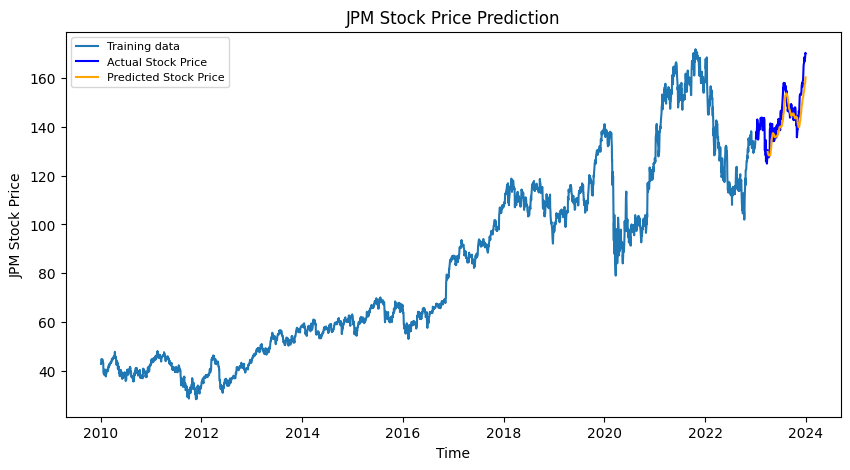

In [191]:
#Visualizing Actual Stock Price vs Predicted Stock Price
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data['Date'], train_data['Close'], label='Training data')
plt.plot(test_data['Date'], test_data['Close'], color = 'blue', label='Actual Stock Price')
plt.plot(test_data[60:]['Date'], predicted_stock_price, color = 'orange',label='Predicted Stock Price')

plt.title('JPM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('JPM Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [197]:
from os import access
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import numpy as np
import math

y_true = test_data[60:]['Close'].values
y_pred = predicted_stock_price

#Report performance
mse = mean_squared_error(y_true, y_pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_true, y_pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))
print('MAPE: '+str(mape))

MSE: 33.57285185245625
MAE: 4.546432093570107
RMSE: 5.794208475059924
MAPE: 0.06502364687665482
